In [1]:
import torch
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from tinyai.imports import *
from torcheval.metrics import *
import itertools
from sklearn.metrics import confusion_matrix
import timm

/home/billy/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/billy/base/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 100

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=10

# Load the FashionMNIST dataset from Hugging Face
dataset = load_dataset('fashion_mnist')
bs=512
epochs = 25
lr = 1e-2
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b['image'] = [(((F.pad(TF.to_tensor(o), (2,2,2,2))) -xmean)/xstd) for o in b['image']]


tds = dataset.with_transform(transformi)
dls = DataLoaders.from_dd(tds,batch_size=bs,test=True ,split = 0.1, num_workers=10, pin_memory=True)
xb,yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(-0.1855), tensor(0.9400))

# Eval models

In [4]:
def get_model(act=GeneralRelu,norm=False):
    layers = [ResBlock(1, 16, stride=1, act=act, norm=norm),
              # Why we stride 2 here? Because we want to reduce the size of the image by half
              ResBlock(16, 32, stride=2, act=act, norm=norm),
              ResBlock(32, 64, stride=2, act=act, norm=norm),
              ResBlock(64, 128, stride=2, act=act, norm=norm),
              ResBlock(128, 256, stride=2, act=act, norm=norm),
              ResBlock(256, 512, stride=2, act=act, norm=norm),
              nn.Flatten(),
              nn.Linear(512, 10, bias=False),
        ]
    if norm:
        layers.append(nn.BatchNorm1d(10))
    return nn.Sequential(*layers)

iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy_metric = MulticlassAccuracy(num_classes=10)
precision_metric = MulticlassPrecision(num_classes=10, average="weighted")
recall_metric = MulticlassRecall(num_classes=10, average="weighted")

# Prepare for confusion matrix
def test_model(model):
    all_preds = []
    all_targets = []
    model.eval()  # Set the model to evaluation mode
    model.to('cuda')  # Move the model to the GPU
    with torch.no_grad():
        for data, target in dls.test:
            data = data.to('cuda')
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            
            # Update torcheval metrics
            accuracy_metric.update(preds, target)
            precision_metric.update(preds, target)
            recall_metric.update(preds, target)

            # Store predictions and targets for confusion matrix
            all_preds.append(preds)
            all_targets.append(target)
    
    stats = {"accuracy": accuracy_metric.compute(),
             "precision": precision_metric.compute(),
             "recall": recall_metric.compute()}
    return torch.cat(all_preds), torch.cat(all_targets), stats

our_model epoch=25 {'accuracy': tensor(0.9185), 'precision': tensor(0.9211), 'recall': tensor(0.9185)}
resnet10t epoch=25 {'accuracy': tensor(0.9100), 'precision': tensor(0.9130), 'recall': tensor(0.9100)}
resnet18 epoch=25 {'accuracy': tensor(0.9032), 'precision': tensor(0.9077), 'recall': tensor(0.9032)}
resnet50 epoch=25 {'accuracy': tensor(0.9014), 'precision': tensor(0.9038), 'recall': tensor(0.9014)}
resnet50_lr epoch=25 {'accuracy': tensor(0.8987), 'precision': tensor(0.9001), 'recall': tensor(0.8987)}
our_model epoch=20 {'accuracy': tensor(0.9013), 'precision': tensor(0.9030), 'recall': tensor(0.9013)}
resnet10t epoch=20 {'accuracy': tensor(0.8999), 'precision': tensor(0.9021), 'recall': tensor(0.8999)}
resnet18 epoch=20 {'accuracy': tensor(0.8988), 'precision': tensor(0.9008), 'recall': tensor(0.8988)}
resnet50 epoch=20 {'accuracy': tensor(0.8960), 'precision': tensor(0.8978), 'recall': tensor(0.8960)}
resnet50_lr epoch=20 {'accuracy': tensor(0.8954), 'precision': tensor(0.896

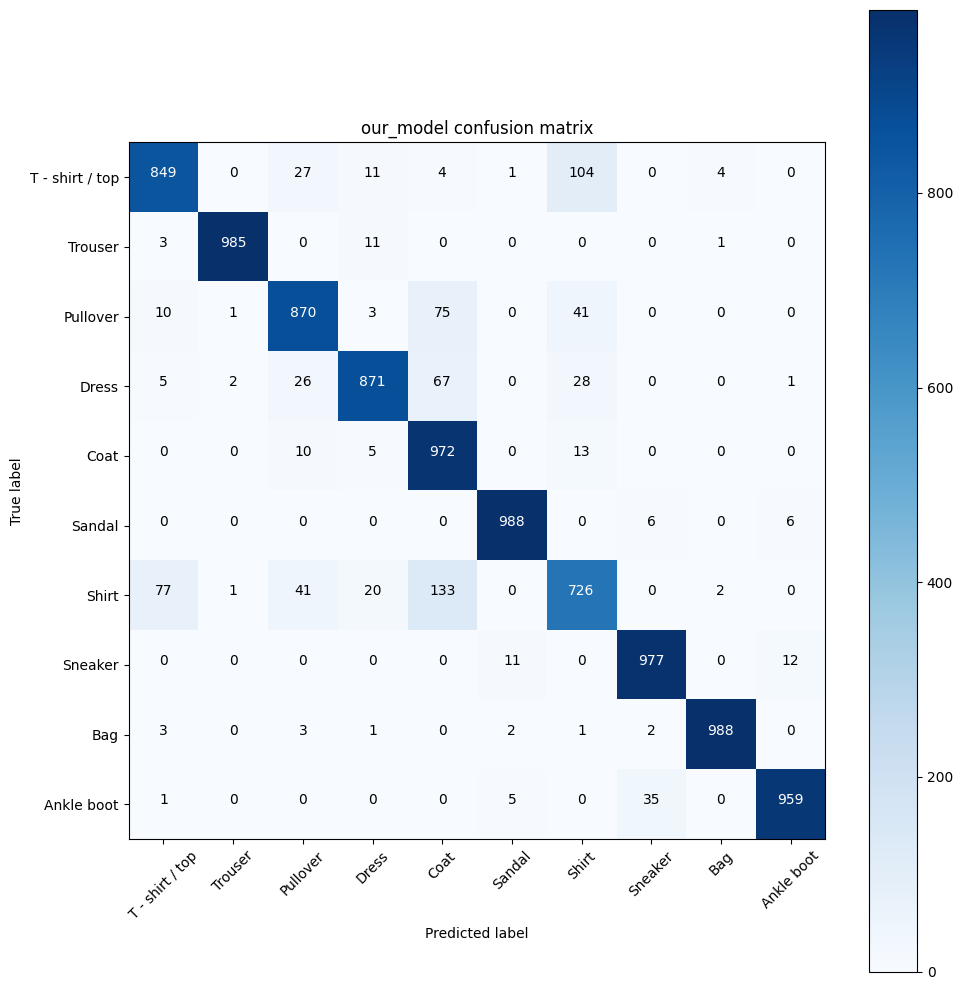

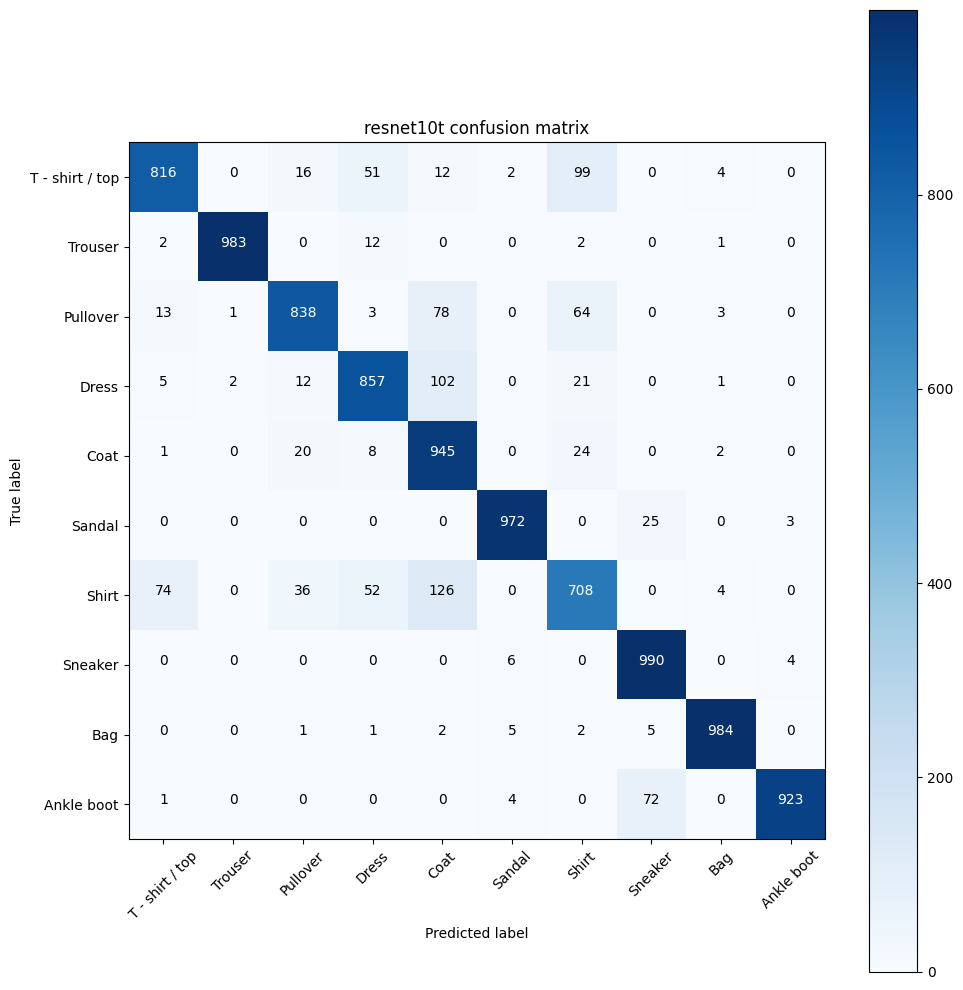

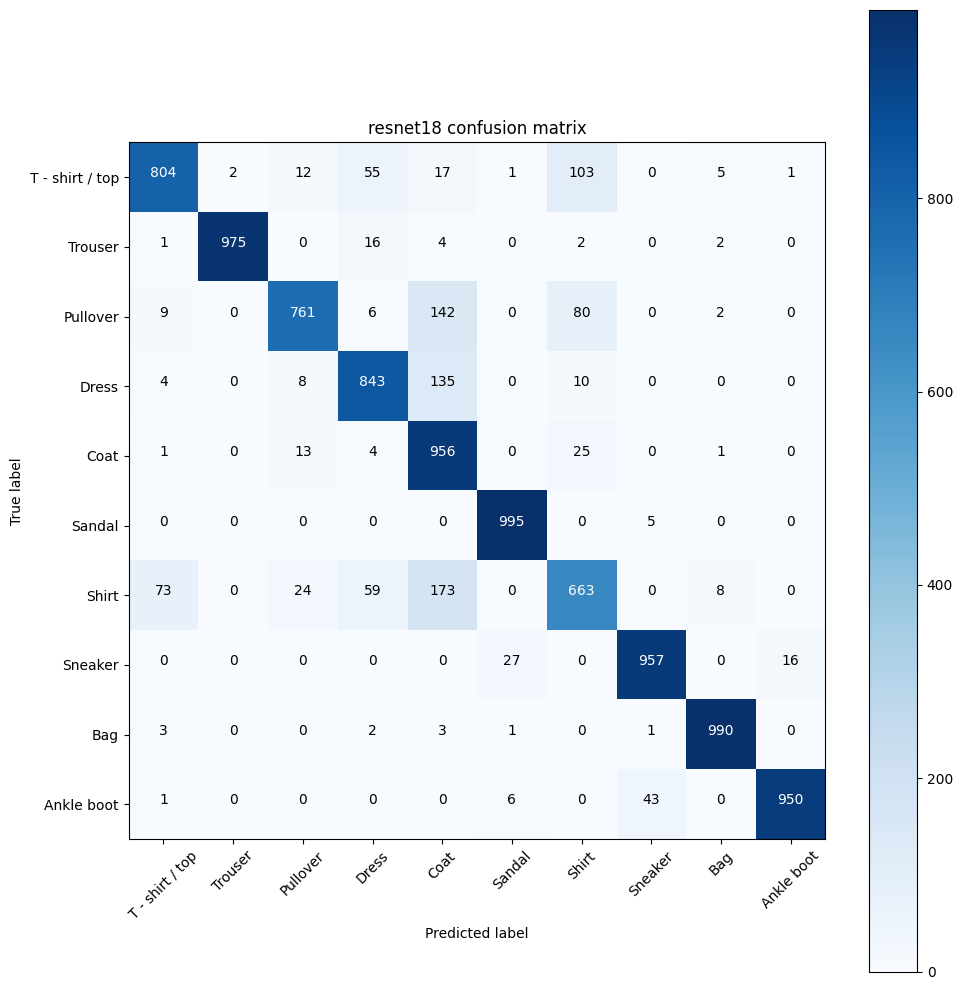

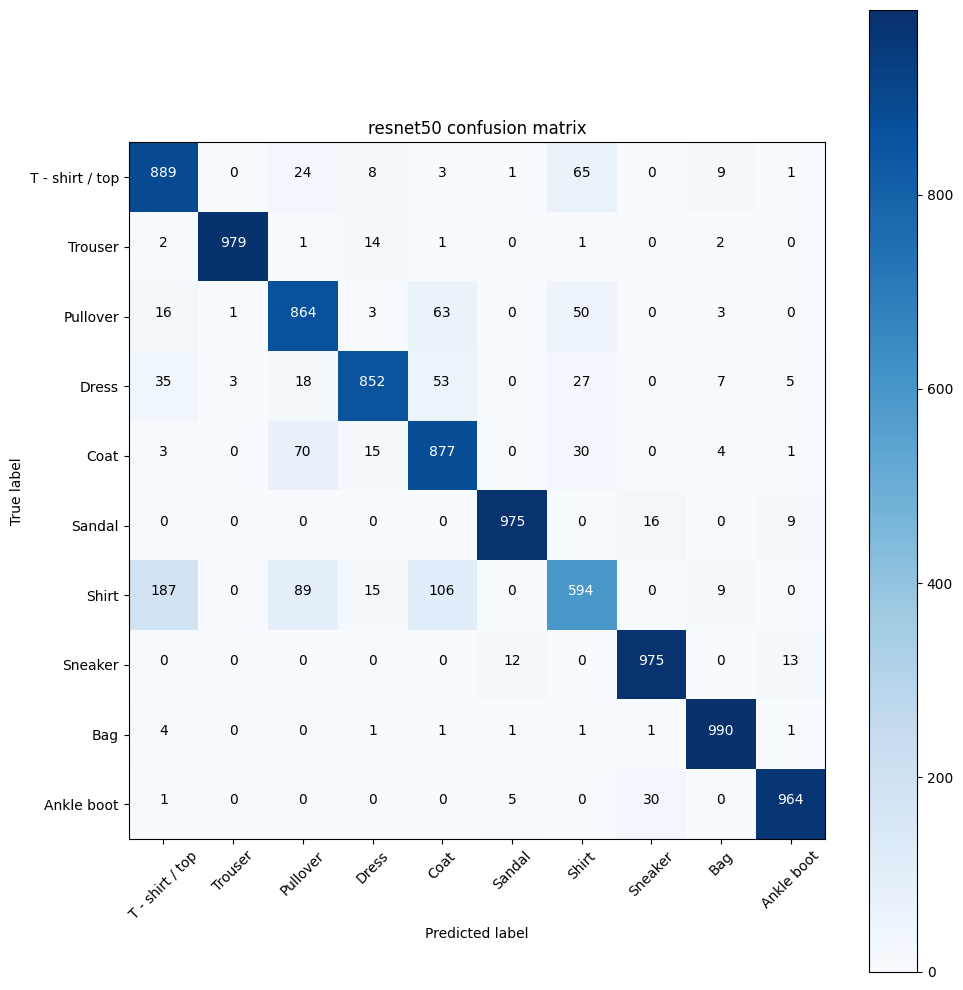

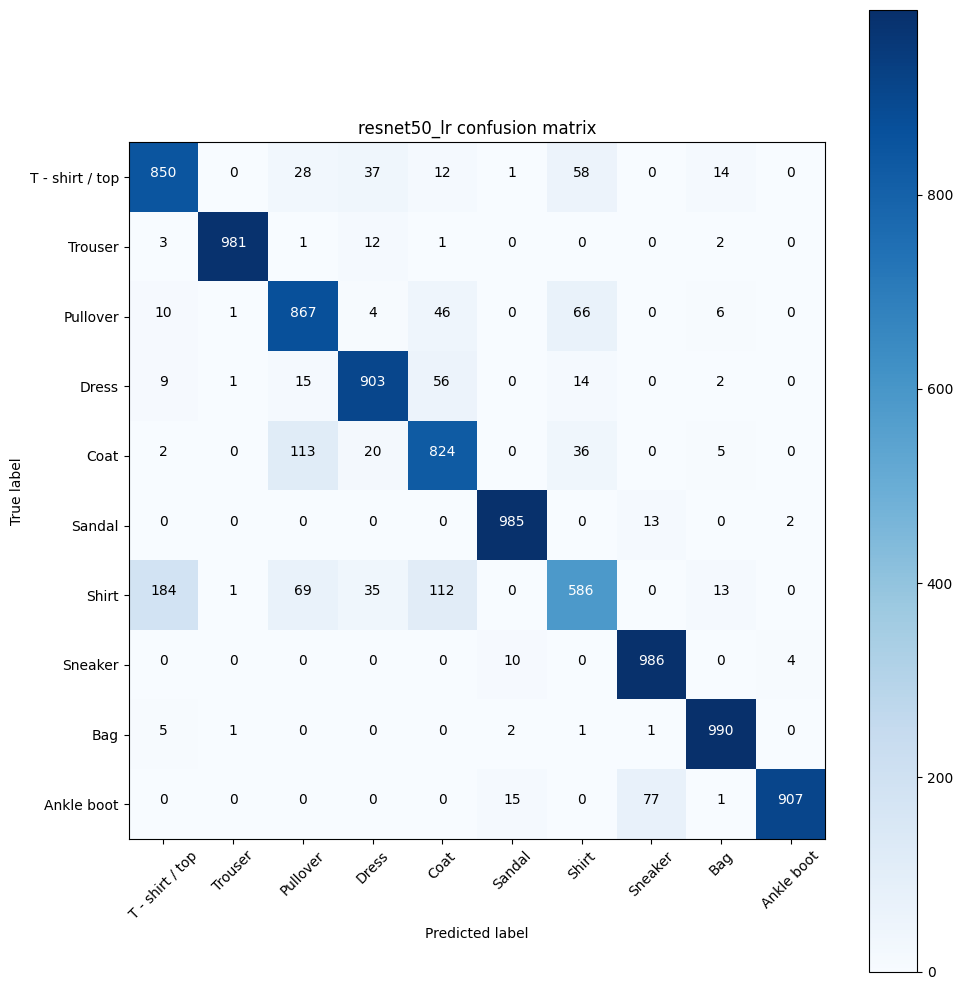

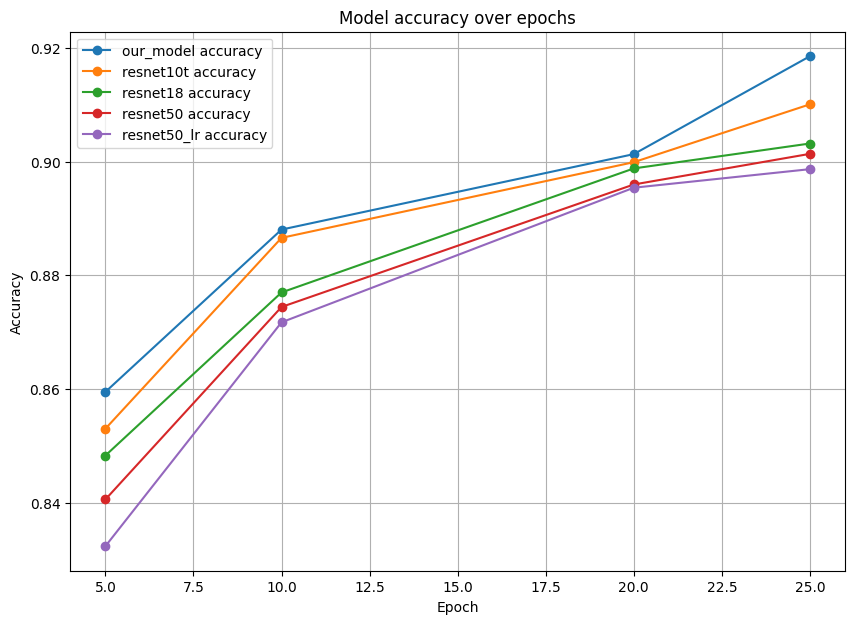

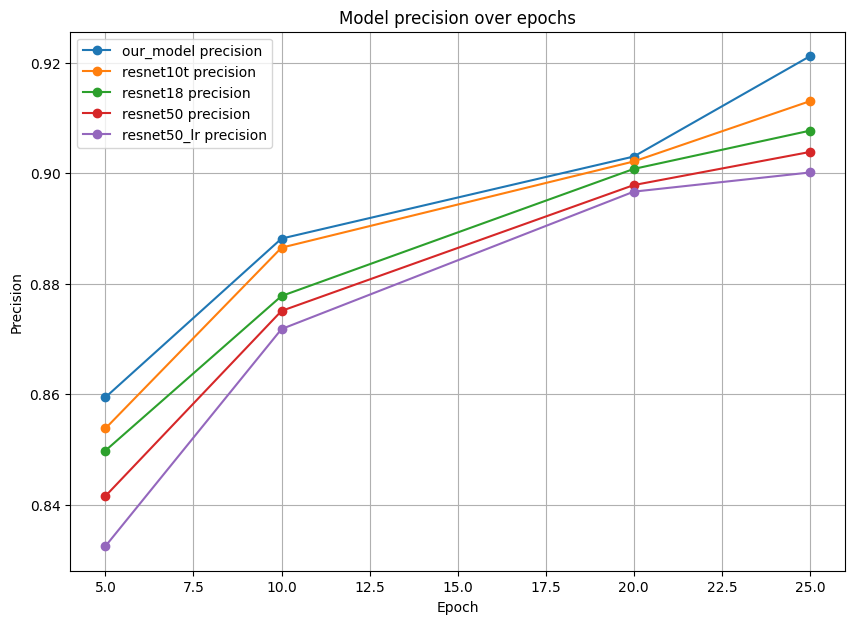

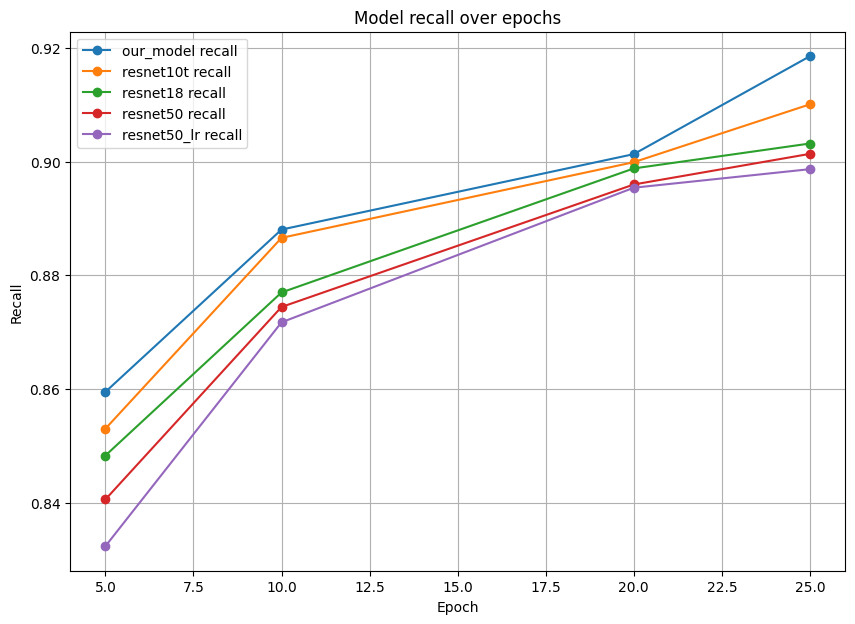

In [6]:
models_names = ['our_model', 'resnet10t', 'resnet18', 'resnet50', 'resnet50_lr']
stats_history = {name: {"accuracy": [], "precision": [], "recall": []} for name in models_names}
epochs = [25,20,10,5]
for epoch in epochs:
    state_dict = torch.load(f'models/AdamW_fix_{epoch}.pth')
    our_model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw).to(def_device)
    our_model.load_state_dict(state_dict)

    resnet18 = timm.create_model('resnet18d', pretrained=False, num_classes=10, in_chans=1)
    resnet18.load_state_dict(torch.load(f'models/ResNet18_{epoch}.pth'))

    resnet50 = timm.create_model('resnet50', pretrained=False, num_classes=10, in_chans=1)
    resnet50.load_state_dict(torch.load(f'models/resnet50_v_{epoch}.pth'))

    resnet10t = timm.create_model('resnet10t', pretrained=False, num_classes=10, in_chans=1)
    resnet10t.load_state_dict(torch.load(f'models/resnet10t_{epoch}.pth'))

    resnet_50_lr = timm.create_model('resnet50', pretrained=False, num_classes=10, in_chans=1)
    resnet_50_lr.load_state_dict(torch.load(f'models/ResNet50_{epoch}.pth'))

    for idx, model in enumerate([our_model,resnet10t,resnet18, resnet50, resnet_50_lr]):
        name = models_names[idx]
        all_preds, all_targets, stats = test_model(model)
        stats_history[name]["accuracy"].append(stats["accuracy"])
        stats_history[name]["precision"].append(stats["precision"])
        stats_history[name]["recall"].append(stats["recall"])
        print(name +" epoch="+ str(epoch), stats)
        if epoch == 25:
            conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.cpu())
            plt.figure(figsize=(10, 10))
            plot_confusion_matrix(conf_matrix, classes=dataset['train'].features['label'].names, title=f'{name} confusion matrix')
    del our_model, resnet10t, resnet18, resnet50


for metric in ["accuracy", "precision", "recall"]:
    plt.figure(figsize=(10, 7))
    for name in stats_history:
        plt.plot(epochs, stats_history[name][metric], marker='o', label=f'{name} {metric}')
    plt.title(f'Model {metric} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# paramcount

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_params = count_parameters(our_model)
resnet10t_params = count_parameters(resnet10t)
resnet18_params = count_parameters(resnet18)
resnet50_params = count_parameters(resnet50)

print("Number of parameters in 'model'      :", model_params)
print("Number of parameters in 'resnet10t'  :", resnet10t_params)
print("Number of parameters in 'resnet18'   :", resnet18_params)
print("Number of parameters in 'resnet50'   :", resnet50_params)

Number of parameters in 'model'      : 4903236
Number of parameters in 'resnet10t'  : 4927186
Number of parameters in 'resnet18'   : 11200298
Number of parameters in 'resnet50'   : 23522250
